In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

N=1000
num_bins=50

# I. Monte-Carlo for some explicit multiplicative free convolutions.

Recall that the Marchenko-Pastur law is the universal limit for singular values of Gaussian matrices. Following Marchenko and Pastur (1967)
$$ \frac{1}{2 \pi} \frac{\sqrt{(x-l)(r-x)}}{x} dx ,$$
where 
$$r = (1+\sqrt{c})^2$$
$$l = (1-\sqrt{c})^2$$
and $c$ being the scale parameter.

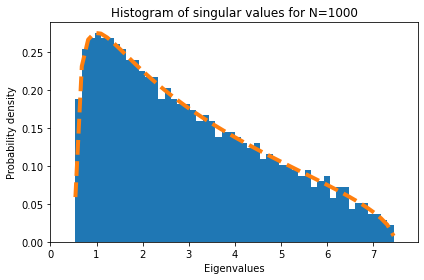

In [2]:
c = 3 # MP scale parameter
r = (1+np.sqrt(c))**2 #Right end
l = (1-np.sqrt(c))**2 #Left end

G = np.random.normal( size=(N,c*N) )
W = G.dot( G.transpose() )
W = W/N
diag, U = np.linalg.eig(W)

# Histogram of singular values
fig, ax = plt.subplots()
n, bins, patches = ax.hist(diag, num_bins, density=True)
y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins)
ax.plot(bins, y, '--', linewidth=4)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of singular values for N={}'.format(N))
fig.tight_layout()
plt.xlim(0,r+0.5)
plt.show()

# II. Cauchy-Stieljes transform: Empirical vs Theoretical

For convenience, let us compute:
$$ G(z) = \int_\mathbb{R} \frac{\mu_{MP}(dt)}{z-t}$$

In [3]:
def G_theoretical(z):
    sqrt = np.sqrt( (z-c-1)*(z-c-1)-4*c )
    positive_imag = (np.imag(sqrt)>0)
    sqrt = positive_imag*sqrt - (1-positive_imag)*sqrt
    #res = (z+c-1-sqrt)/(2*c*z)-2/(c*z)
    #return res*c
    return (z-c+1-sqrt)/(2*z)

def G_empirical(z):
    array = z[...,None]-diag[...,:]
    return np.sum( 1/array, axis=-1)/len(diag)

def G_prime_empirical(z):
    array = z[...,None]-diag[...,:]
    return np.sum( -1/(array*array), axis=-1)/len(diag)

def G_second_empirical(z):
    array = z[...,None]-diag[...,:]
    return np.sum( 2/(array*array*array), axis=-1)/len(diag)

def M_theoretical(z):
    return z*G_theoretical(z)-1

def M_empirical(z):
    return z*G_empirical(z)-1

def M_prime_empirical(z):
    return z*G_prime_empirical(z) + G_empirical(z)

def M_second_empirical(z):
    return z*G_second_empirical(z) + 2*G_prime_empirical(z)

z0 = np.array( complex(1.0+1.0j) )
print(z0)
print( G_theoretical(z0) )
print( G_empirical(z0) )

(1+1j)
(-0.2751252613501688-0.40867701051198535j)
(-0.2745774495493335-0.40988075819901404j)


### II. 1. Zeroes of the second kind

In [ ]:
def newton_raphson( f, f_prime, initial, maxiter=20, tol=1e-8):
    z = initial
    k = 0
    while k<max_iter:
        value = f(z)
        derivative_value = f_prime(z)
        z = z - value/derivative_value
        if value<tol:
            break
    return z

zeroes_first_kind  = diag
zeroes_second_kind = np.array( size=len(diag)-1)
for i in range( len(diag) - 1):
    initial = ( diag[i] + diag[i+1] )/2
    zeroes_second_kind[i] = newton_raphson( G_empirical, G_prime_empirical, initial )

### II. 2. Prefer the argument principle

Eigenvalues
min:  0.5417025704487951
max:  7.44510083338938


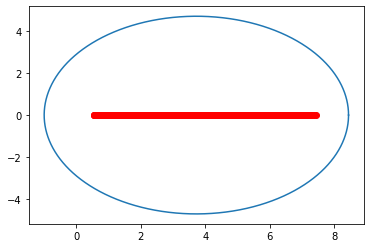

Index:  (-2.000247944551795-0j)
Root count:  (1997.9997520554482+0j)


In [5]:
degree = len(diag)

print("Eigenvalues")
print("min: ", np.min(diag))
print("max: ", np.max(diag))

mesh_size = 10000
radius = np.max(diag)/2 + 1
center = np.max(diag)/2
interval = np.linspace(0, 2*np.pi, mesh_size)
contour = center + radius*( np.cos(interval) + np.sin(interval)*1.0j)
plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.plot( np.real(contour), np.imag(contour) )
plt.show()

values = M_second_empirical(contour)/M_prime_empirical(contour)
#values = 1/(contour)
dz = 1.0j*(contour-center)*2*np.pi/(mesh_size) 
index  = np.sum(dz*values)/(2*np.pi*1.0j)
print( "Index: ", index)
print( "Root count: ", index+2*degree)


In [6]:
def compute_index( box, mesh_size, plot=True, color='b'):
       interval =  np.linspace( 0,1, mesh_size)
       segments = []

       s = box['bottom_right'] + interval*( box['top_right'] - box['bottom_right'] )
       segments.append( s )
       s = box['top_right'] + interval*( box['top_left'] - box['top_right'] )
       segments.append( s )
       s = box['top_left'] + interval*( box['bottom_left'] - box['top_left'] )
       segments.append( s )
       s = box['bottom_left'] + interval*( box['bottom_right'] - box['bottom_left'] )
       segments.append( s )

       integral = 0
       for s in segments:
              values = M_second_empirical(s)/M_prime_empirical(s)
              dz = ( s[-1]-s[0] )/mesh_size
              integral = integral + np.sum( values*dz )
              #
              if plot:
                     x = np.real(s)
                     y = np.imag(s)
                     plt.plot( x, y, c=color)
       return integral/(2*np.pi*1.0j)

def extend_box( box ):
       extended_box = box
       span   = extended_box['top_left']-extended_box['bottom_right']
       height = np.abs( np.imag(span) )
       width  = np.abs( np.real(span) )
       extended_box['top_right']   = extended_box['top_left']     + width
       extended_box['bottom_left'] = extended_box['bottom_right'] - width
       extended_box['height'] = height
       extended_box['width']  = width
       return extended_box

Index:  1998.0000676428401
Root count:  1998.0


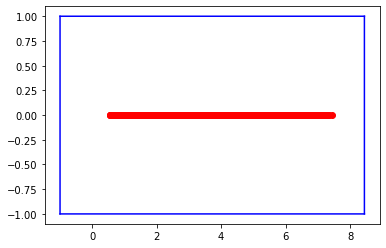

In [7]:
mesh_size = 10000
radius = 1
box = {
       'top_left'    : -1.0 + radius*1.0j,
       'bottom_right': np.max(diag) + 1 - radius*1.0j,
}
box   = extend_box(box)
index = compute_index( box, mesh_size, plot=True)
index = np.real(index+2*degree)
root_count = np.round( index )
error = index-root_count
print( "Index: ", index)
print( "Root count: ", root_count)

plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.show()


Pass 0:
Index:  1998.000135314254
Root count:  1998.0

Pass 1:
Index:  -4.806905327072091e-05
Root count / Total:  0 / 0

Pass 2:
Index:  -4.184437931395806e-05
Root count / Total:  0 / 0

Pass 3:
Index:  -2.5181627651250565e-05
Root count / Total:  0 / 0

Pass 4:
Index:  22.061826585566603
Root count / Total:  22 / 22

Pass 5:
Index:  33.77225319979148
Root count / Total:  34 / 56

Pass 6:
Index:  83.88666701981818
Root count / Total:  84 / 140

Pass 7:
Index:  118.59265493477267
Root count / Total:  119 / 259

Pass 8:
Index:  220.9016092188352
Root count / Total:  221 / 480

Pass 9:
Index:  283.3038744577927
Root count / Total:  283 / 763

Pass 10:
Index:  146.60927864534884
Root count / Total:  147 / 910



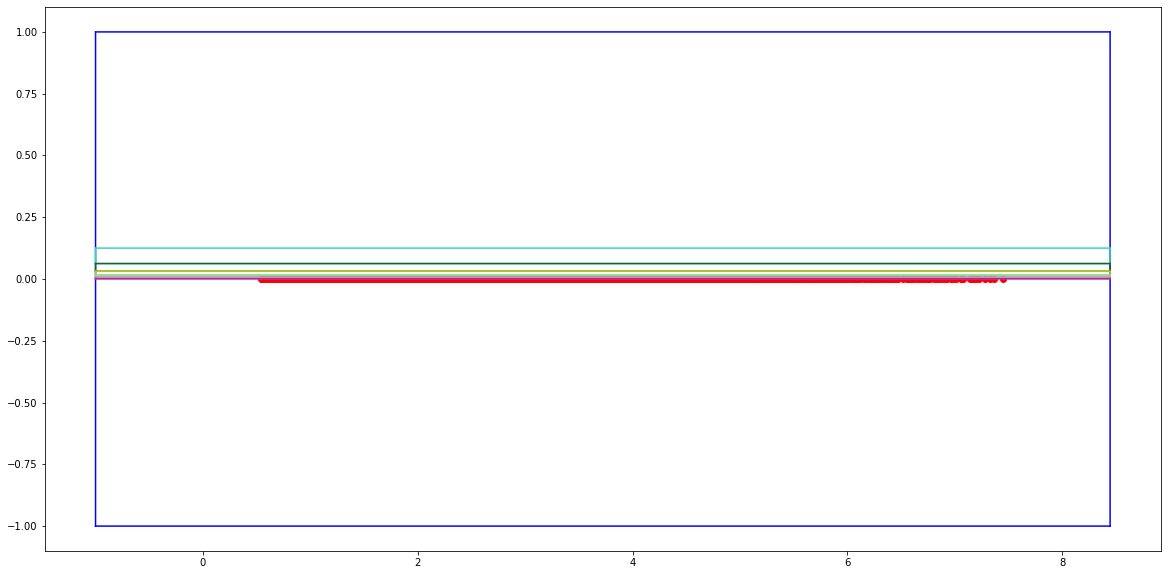

In [8]:
def plot_box( box, mesh_size, color):
    interval =  np.linspace( 0,1, mesh_size)
    segments = []

    s = box['bottom_right'] + interval*( box['top_right'] - box['bottom_right'] )
    segments.append( s )
    s = box['top_right'] + interval*( box['top_left'] - box['top_right'] )
    segments.append( s )
    s = box['top_left'] + interval*( box['bottom_left'] - box['top_left'] )
    segments.append( s )
    s = box['bottom_left'] + interval*( box['bottom_right'] - box['bottom_left'] )
    segments.append( s )

    for s in segments:
        x = np.real(s)
        y = np.imag(s)
        plt.plot( x, y, c=color)      

    return

mesh_size = 5000

plt.figure( figsize=(20,10) )

# Pass 0: Bounding box
print("Pass 0:")
radius = 1
box = {
       'top_left'    : -1.0 + radius*1.0j,
       'bottom_right': np.max(diag) + 1 - radius*1.0j,
}
box   = extend_box(box)
index = compute_index( box, mesh_size, plot=True)
index = np.real(index+2*degree)
root_count = np.round( index )
error = index-root_count
print( "Index: ", index)
print( "Root count: ", root_count)
print( "")


root_counter = 0
box['bottom_left'] = box['top_left'] # For initialization, bottom_left needs to be the previous top_left

# Loop for multiple passes and more
boxes_with_roots = []
for i in range(10):
       print(f"Pass {i+1}:")
       #print("Height: ", radius)
       radius = radius/2
       box = {
              'top_left'    : box['bottom_left'],
              'bottom_right': np.max(diag) + 1 + radius*1.0j,
       }
       box   = extend_box(box)
       index = compute_index( box, mesh_size, plot=False)
       index = np.real(index)
       root_count = int( np.round( index ) )
       root_counter = root_counter + root_count
       error = index-root_count
       print( "Index: ", index)
       print( "Root count / Total: ", root_count, '/', root_counter)
       print( "")
       #
       if root_count>0:
              box['root_count'] = root_count
              boxes_with_roots.append( box )
#

# Plotting
for box in boxes_with_roots:
       color = np.random.rand(3)
       plot_box( box, mesh_size, color)
plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.show()

In [9]:
def split_box( box ):
    span = box['top_left']-box['bottom_right']
    span = ( abs(np.real(span)), abs(np.imag(span)) )
    if span[0] > span[1]:
        box1 = {
            'top_left'    : box['top_left'],
            'bottom_right': box['bottom_right']-0.5*span[0],
        }
        box2 = {
            'top_left'    : box['top_left']+0.5*span[0],
            'bottom_right': box['bottom_right'],
        }
    else:
        box1 = {
            'top_left'    : box['top_left'],
            'bottom_right': box['bottom_right']+0.5*span[1]*1.0j,
        }
        box2 = {
            'top_left'    : box['top_left']-0.5*span[1]*1.0j,
            'bottom_right': box['bottom_right'],
        }
    #
    box1 = extend_box( box1 )
    box2 = extend_box( box2 )
    return box1, box2

def refine_boxes( coarse_boxes ):
    refined_boxes = []
    for box in coarse_boxes:
        split_boxes = split_box( box )
        #
        for refined_box in split_boxes:
            index = compute_index( refined_box, mesh_size, plot=False)
            index = np.real(index)
            root_count = int( np.round( index ) )
            if root_count>0:
                refined_box['root_count'] = root_count
                refined_boxes.append( refined_box )
    return refined_boxes

refined_boxes = boxes_with_roots
print("Pass / Number of refined boxes / Total number of roots:")
for i in range(15):
    refined_boxes = refine_boxes( refined_boxes )
    counts = [ box['root_count'] for box in refined_boxes]
    print( i+1, ": ", len(refined_boxes), " / ", np.sum(counts) )

Pass / Number of refined boxes / Total number of roots:
1 :  14  /  912
2 :  26  /  908
3 :  42  /  906
4 :  80  /  909
5 :  146  /  909
6 :  256  /  909
7 :  402  /  909
8 :  569  /  909
9 :  733  /  909
10 :  833  /  909
11 :  889  /  909
12 :  907  /  909
13 :  908  /  909
14 :  909  /  909
15 :  909  /  909


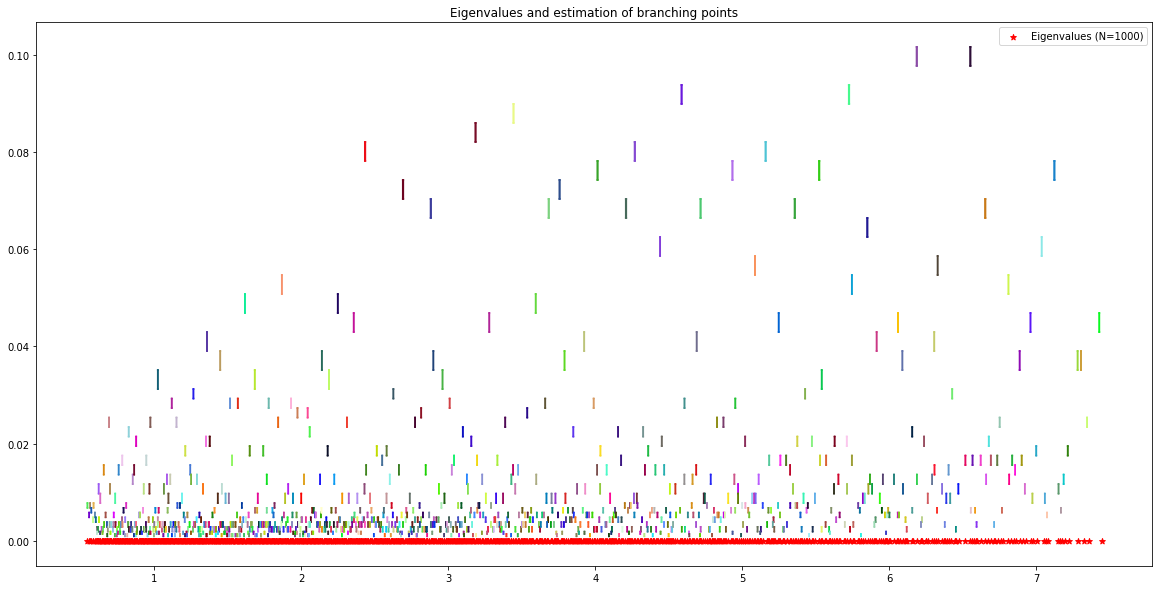

In [11]:
# Plotting
plt.figure( figsize=(20,10) )
for box in refined_boxes:
       color = np.random.rand(3)
       plot_box( box, mesh_size, color)
plt.scatter( np.real(diag), np.imag(diag), marker='*', c='r', label=f'Eigenvalues (N={N})')
plt.title( 'Eigenvalues and estimation of branching points')
plt.legend()
plt.show()

In [ ]:
xmin = 0
xmax = 10
ymin = 0.1
ymax = 5

#Multiple passes for the number of iterations
imaginary_parts = [1.0, 0.5, 0.1, 0.001]

space_grid = np.linspace(xmin, xmax, 100)
pass_counter = 0
j       = complex(0,1)
fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
for y in imaginary_parts:
    start = time.time()
    # Compute
    z = np.array( space_grid + y*complex(0,1) )
    G = G_theoretical(z)
    # Statistics
    pass_counter += 1
    timing        = time.time() - start
    print ('Pass [{}/{}], Duration: {:.1f} ms' 
           .format(pass_counter, len(imaginary_parts), 1000*timing))
    print("")
    # Plot
    ax.plot(space_grid, -np.imag(G)/np.pi, '--', label="y=%.5f"%y)
    ax.set(xlabel='Space (x)', ylabel='Value',
           title='Density')
    ax.grid()
    #
    y_proxy = y
plt.ylim(0,0.3)
plt.legend()
plt.show()

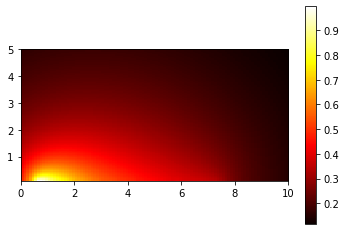

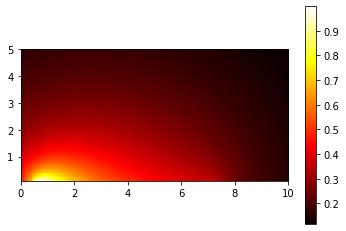

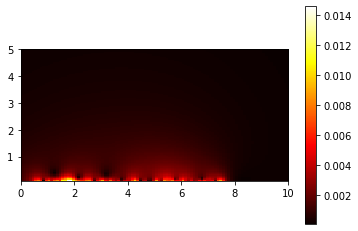

In [6]:

x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)
xv, yv = np.meshgrid(x, y)
z_grid = xv+yv*complex(1.0j)

# Empirical
G_grid = G_empirical( z_grid )
G_grid = np.flip( G_grid, axis=0)
plt.imshow( np.abs(G_grid), cmap='hot', interpolation='nearest', extent=[xmin, xmax, ymin, ymax])
plt.colorbar()
plt.show()

# Theoretical
G_grid2 = G_theoretical( z_grid )
G_grid2 = np.flip( G_grid2, axis=0)
plt.imshow( np.abs(G_grid2), cmap='hot', interpolation='nearest', extent=[xmin, xmax, ymin, ymax])
plt.colorbar()
plt.show()

# Difference
Diff = np.abs(G_grid2-G_grid)
plt.imshow( Diff, cmap='hot', interpolation='nearest', extent=[xmin, xmax, ymin, ymax])
plt.colorbar()
plt.show()

## III. Inversion (NOT DONE)

In [1]:
!pip3 install jupyterlab
!pip3 install ipympl

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [7]:
%matplotlib widget

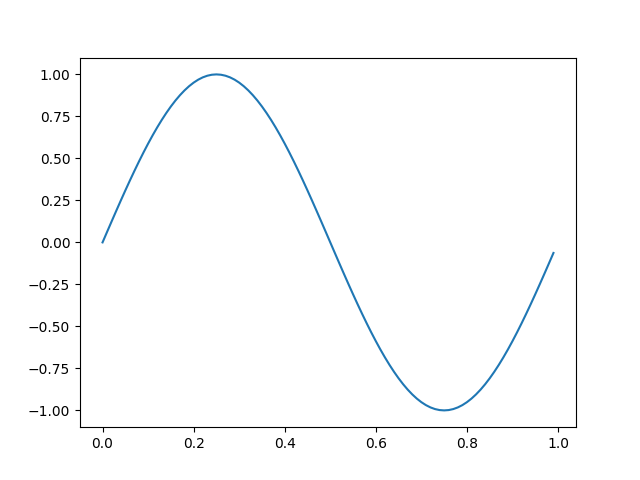

In [8]:
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2 * np.pi * t)
fig, ax = plt.subplots()
ax.plot(t, s)


def on_move(event):
    # get the x and y pixel coords
    x, y = event.x, event.y
    if event.inaxes:
        ax = event.inaxes  # the axes instance
        print('data coords %f %f' % (event.xdata, event.ydata))


def on_click(event):
    if event.button is MouseButton.LEFT:
        print('disconnecting callback')
        plt.disconnect(binding_id)


binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)

plt.show()